In [2]:
#kütüphaneleri import etme
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from mpl_toolkits.axes_grid1 import ImageGrid
from tensorflow.keras.applications import EfficientNetV2M
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam,Adamax

In [ ]:
import os
import pandas as pd
#data  
# https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/data
no = [r'']
yes = [r'']
file_p = []
labels = []
dict_lists = [no, yes] #no saglikli, yes hasta
class_labels = ['no', 'yes']
# Dosya yollarını ve etiketleri toplama
for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        list_f = os.listdir(j)
        for name in list_f:
            fpath = os.path.join(j, name)
            file_p.append(fpath)
            labels.append(class_labels[i])

# DataFrame oluşturma
failpath = pd.Series(file_p, name="filepaths")
Labelss = pd.Series(labels, name="labels")
data = pd.concat([failpath, Labelss], axis=1)
df = pd.DataFrame(data)

# DataFrame'in ilk birkaç satırını kontrol etme
print(df.head())

In [ ]:
df.head()

In [5]:
# egitim, test, dogrulama bölümlerine ayırma
train_df, test_df = train_test_split(df, test_size=0.25, random_state=42,stratify=df.labels)
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=42,stratify=train_df.labels)
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(160, 2)
(64, 2)
(29, 2)


In [6]:
#görüntü işleme
def enhance_image(image):
    image = cv2.addWeighted(image, 1.5, image, -0.5, 0)
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    image = cv2.filter2D(image, -1, kernel)
    hue = image[:, :, 0]
    saturation = image[:, :, 1]
    value = image[:, :, 2]
    value = np.clip(value * 1.25, 0, 255)
    image[:, :, 2] = value
    return image

In [7]:
#Keras Kullanarak görüntü cerceveleme 
image_gen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=lambda image: enhance_image(image))
train = image_gen.flow_from_dataframe(dataframe= train_df,x_col="filepaths",y_col="labels",
                                      target_size=(256,256),
                                      color_mode='rgb',
                                      class_mode="categorical", 
                                      batch_size=64,
                                      shuffle=False            
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_df,x_col="filepaths", y_col="labels",
                                     target_size=(256,256),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=64,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_df,x_col="filepaths", y_col="labels",
                                    target_size=(256,256),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=64,
                                    shuffle=False
                                   )

Found 160 validated image filenames belonging to 2 classes.
Found 64 validated image filenames belonging to 2 classes.
Found 29 validated image filenames belonging to 2 classes.


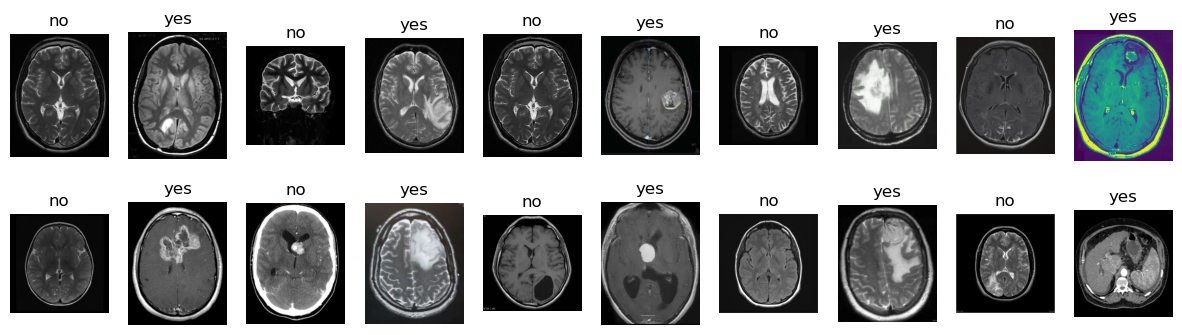

In [8]:
# matplotlib ile 10 hasta, 10 sağlıklı rastgele görsel çizdirme
import matplotlib.pyplot as plt
num_images_per_class = 10
class_labels = list(train.class_indices.keys())
plt.figure(figsize=(15, 4))
for label in class_labels:
    indices = train_df[train_df['labels'] == label].index
    indices = np.random.choice(indices, min(num_images_per_class, len(indices)), replace=False)
    
    # Görselleri çizme
    for i, idx in enumerate(indices):
        plt.subplot(len(class_labels), num_images_per_class, len(class_labels)*i + class_labels.index(label) + 1)
        plt.imshow(plt.imread(train_df.loc[idx, 'filepaths']))  # Load and plot the image
        plt.title(label)
        plt.axis('off')
plt.show()

In [9]:
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.models import Model
from tensorflow.keras.applications import Xception
learning_rate = 0.001
base_model = Xception(weights='imagenet', include_top=False, pooling='max')
x = base_model.output
x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
optimizer = Adamax(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
# Modeli Eğitme
history = model.fit(train, epochs=100, validation_data=val)

Epoch 1/100


c:\Users\ns2ru\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 70s 18s/step - accuracy: 0.5302 - loss: 1.1788 - val_accuracy: 0.3793 - val_loss: 5.0436
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 40s 12s/step - accuracy: 0.9570 - loss: 0.1588 - val_accuracy: 0.3793 - val_loss: 5.8392
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 41s 12s/step - accuracy: 0.9688 - loss: 0.0844 - val_accuracy: 0.3793 - val_loss: 6.5903
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 40s 12s/step - accuracy: 0.9758 - loss: 0.0384 - val_accuracy: 0.3793 - val_loss: 6.2461
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 40s 12s/step - accuracy: 1.0000 - loss: 0.0143 - val_accuracy: 0.3793 - val_loss: 5.4782
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 41s 17s/step - accuracy: 0.9969 - loss: 0.0096 - val_accuracy: 0.3793 - val_loss: 5.0008
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 40s 12s/step - accuracy: 1.0000 - loss: 0.0067 - val_accuracy: 0.4138 - val_loss: 4.9167
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 39s 12s/step - accuracy: 1.0000 - loss: 0.0037 - val_accuracy: 0.4138 - val_loss: 4.7392
Epoc

In [10]:
loss, accuracy = model.evaluate(test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.9375 - loss: 0.3997
Test Loss: 0.3997397720813751
Test Accuracy: 0.9375


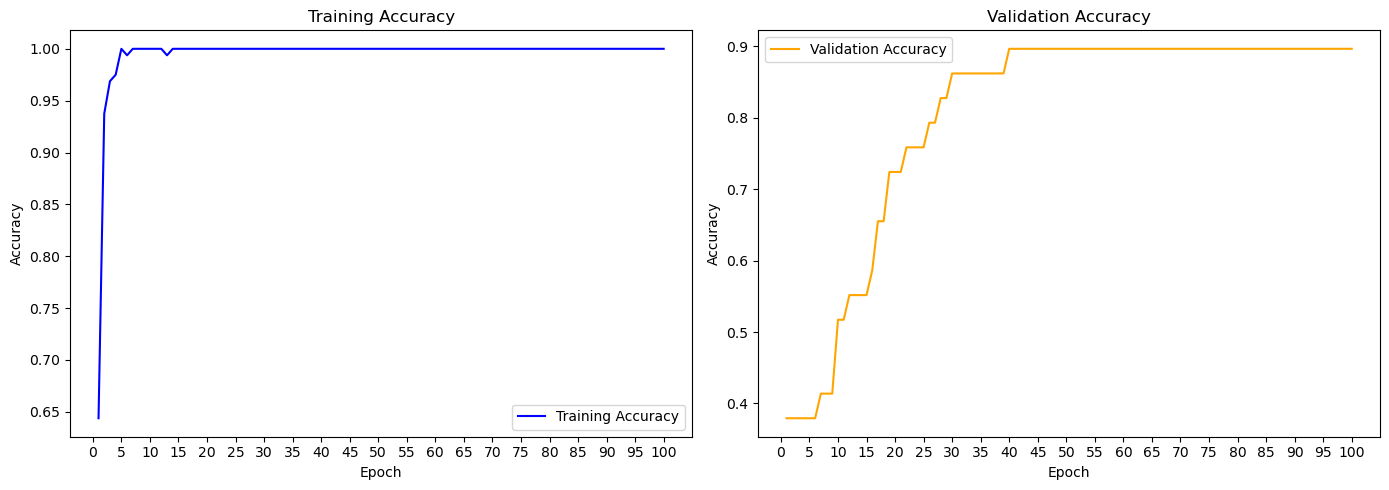

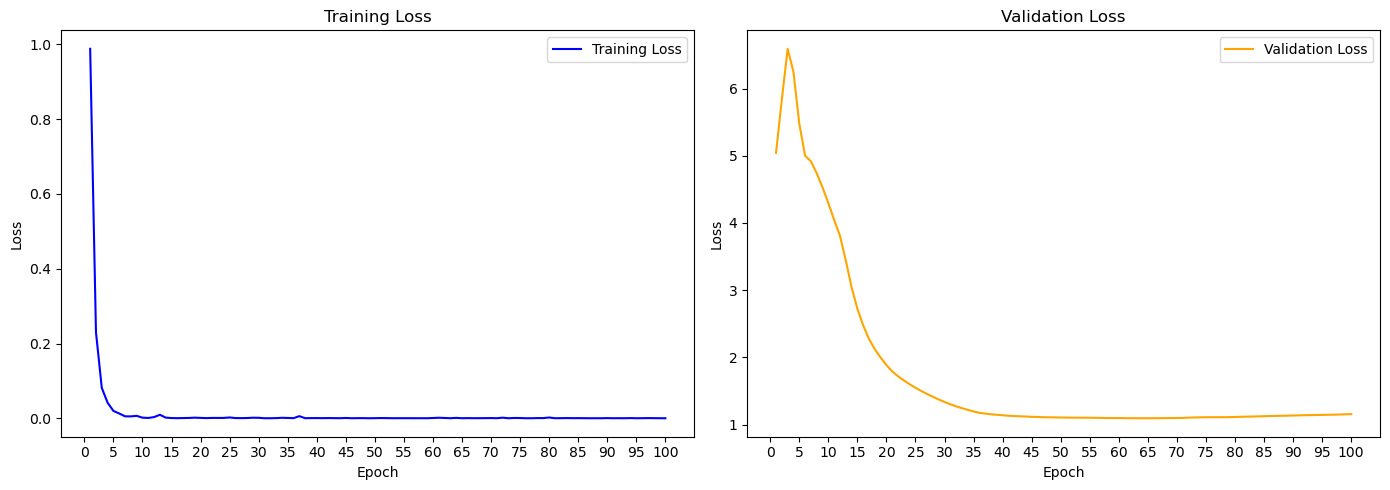

In [11]:
import matplotlib.pyplot as plt
# Eğitim ve doğrulama verilerini alma
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, 101)  # 0'dan 100'e kadar olan epoch'lar
xticks = range(0, 101, 5)  # 0'dan başlayarak her 5 epoch'ta bir
# Eğitim ve doğrulama doğruluklarını plot etme
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Training Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.xticks(xticks)  # X ekseni için belirli epoch'ları ayarlama
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.xticks(xticks)  # X ekseni için belirli epoch'ları ayarlama
plt.tight_layout()
plt.show()
# Eğitim ve doğrulama kayıplarını plot etme
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.xticks(xticks)  # X ekseni için belirli epoch'ları ayarlama
plt.subplot(1, 2, 2)
plt.plot(epochs, val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.xticks(xticks)  # X ekseni için belirli epoch'ları ayarlama
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


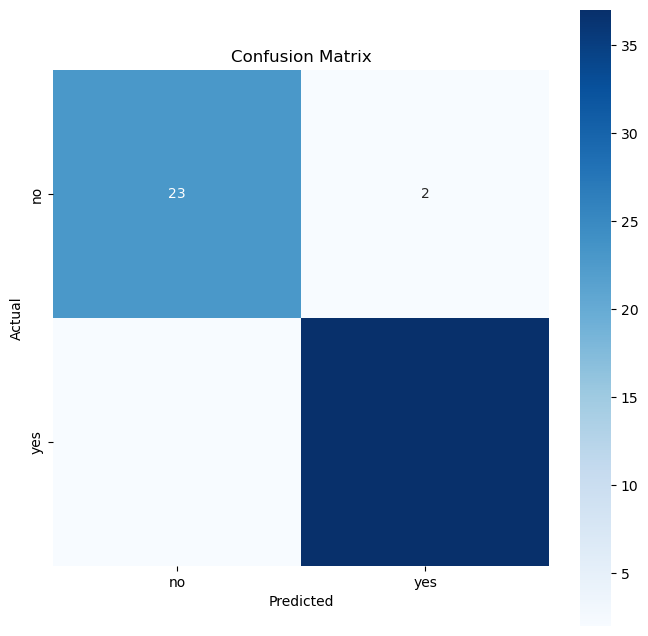

In [12]:
from sklearn.metrics import confusion_matrix
import numpy as np
y_pred = model.predict(test)
y_pred_classes = np.argmax(y_pred, axis=1)
true_classes = test.classes
conf_matrix = confusion_matrix(true_classes, y_pred_classes)
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', square=True, 
            xticklabels=test.class_indices.keys(), yticklabels=test.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

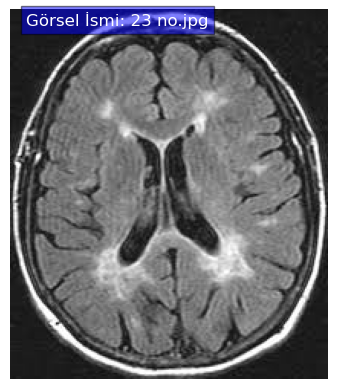

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


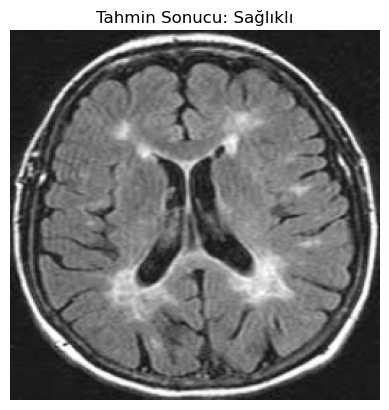

In [26]:
# Random bir numune seçme
random_sample = test_df.sample(n=1).iloc[0]
# Numune yolunu ve etiketini alma
sample_path = random_sample['filepaths']
sample_label = random_sample['labels']
# Seçilen numuneyi gösterme
sample_img = plt.imread(sample_path)
plt.imshow(sample_img)
plt.text(10, 10, f'Görsel İsmi: {os.path.basename(sample_path)}', color='white', fontsize=12, bbox=dict(facecolor='blue', alpha=0.5))
plt.axis('off')
plt.show()
# Numunenin modelde kullanılması ve tahmin yapılması
if sample_img is not None:
    sample_img = cv2.resize(sample_img, (256, 256)) 
    sample_img = np.expand_dims(sample_img, axis=0) / 255.0  

    # Tahmin yapma
    prediction = model.predict(sample_img)
    predicted_label = "Hasta" if np.argmax(prediction) == 1 else "Sağlıklı"  

    # Tahmin sonucunu gösterme
    plt.imshow(sample_img[0])
    plt.title(f'Tahmin Sonucu: {predicted_label}')
    plt.axis('off')
    plt.show()
else:
    print("Görsel okunamadı. Lütfen dosya yolunu kontrol edin.")
